In [ ]:
import torch
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
from torch import nn
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
import torch.optim as optim
from torch.utils.data import DataLoader

In [ ]:
!wget https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/data/lenta_40k.csv.zip

data = pd.read_csv("lenta_40k.csv.zip")

--2025-06-05 15:28:57--  https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/data/lenta_40k.csv.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/refs/heads/master/data/lenta_40k.csv.zip [following]
--2025-06-05 15:28:57--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/refs/heads/master/data/lenta_40k.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30658975 (29M) [application/zip]
Saving to: ‘lenta_40k.csv.zip’

lenta_40k.csv.zip   100%[===================>]  29.24M   105MB/s    in 0.3s    

2025-06-05 15

In [ ]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [ ]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))


filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

# индексируем слова
word2id = {"PAD": 0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [ ]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)

In [ ]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [ ]:
def make_labels(target):
    label = label2id[target]
    return label
data['target'] = data.topic.apply(make_labels)
y =data.target.tolist()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
len(y_train) == len(X_train)

True

In [ ]:
class OurDataset(Dataset):

  def __init__(self, target_list, token_list, word2id, max_len=128):

    self.target_list = target_list
    self.token_list = token_list
    self.max_len = max_len
    self.word2id = word2id
    self.pad_id = word2id['PAD']

  def __len__(self):

    return len(self.token_list)

  def __getitem__(self, idx):

    tokens = self.token_list[idx]
    tokens = tokens[:self.max_len]
    length = len(tokens)
    if length < self.max_len:
      tokens += [self.pad_id] * (self.max_len - length)

    return torch.tensor(tokens), torch.tensor(self.target_list[idx], dtype=torch.long)

In [ ]:
train_set = OurDataset(y_train, X_train, word2id, MAX_LEN)
test_set = OurDataset(y_test, X_test, word2id, MAX_LEN)


train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size = 1024)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, batch_size=1024)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LanguageModel(nn.Module):
    def __init__(self, vocab_size, num_classes, max_len, embedding_dim=100):
        super(LanguageModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.dropout1 = nn.Dropout(0.3)

        self.convs = nn.ModuleList()
        for ks in [3, 5, 7, 9]:
            self.convs.append(nn.Sequential(
                nn.Conv1d(in_channels=embedding_dim, out_channels=32, kernel_size=ks, padding=ks // 2),
                nn.Conv1d(in_channels=32, out_channels=24, kernel_size=ks, padding=ks // 2),
                nn.ReLU(),
                nn.AvgPool1d(kernel_size=5)
            ))

        self.dropout2 = nn.Dropout(0.5)


        pooled_length = max_len // 5
        concat_size = 24 * 4 * pooled_length

        self.fc1 = nn.Linear(concat_size, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        """
        :param x: Tensor of shape (batch_size, max_len)
        :return: Tensor of shape (batch_size, num_classes)
        """
        x = self.embedding(x)                 # (B, L, E)
        x = self.dropout1(x)
        x = x.permute(0, 2, 1)                # (B, E, L) для Conv1D

        conv_outs = []
        for conv in self.convs:
            out = conv(x)                     # (B, 24, L//5)
            conv_outs.append(out)

        x = torch.cat(conv_outs, dim=1)       # (B, 24*4, L//5)
        x = self.dropout2(x)
        x = x.view(x.size(0), -1)             # flatten
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


In [22]:
class NN():

  def __init__(self, model, optimizer, criterion, metric, train_loader, test_loader, num_epochs,scheduler=None, verbose=True, wandb_project=False):
    self.model = model
    self.optimizer = optimizer
    self.criterion = criterion
    self.metric = metric
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.num_epochs = num_epochs
    self.verbose=verbose
    self.wandb_project=wandb_project
    self.scheduler = None

    self.train_losses = []
    self.val_losses = []
    self.train_metrics = []
    self.val_metrics = []

    if self.wandb_project:
            wandb.init(project="my_nn")
            wandb.watch(self.model)

    self.final_y_true = None
    self.final_y_pred = None



  def train(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(device)

        best_val_loss = float("inf")
        patience_counter = 0
        early_stop_patience = 3

        for epoch in range(1, self.num_epochs + 1):
            train_loss = 0.0
            y_true_all, y_pred_all = [], []

            for X_train, y_train in tqdm(self.train_loader, desc=f"Epoch {epoch}/{self.num_epochs}"):
                X_train, y_train = X_train.to(device), y_train.to(device)
                y_pred = self.model(X_train)

                loss = self.criterion(y_pred, y_train)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

                y_true_all.append(y_train.cpu().numpy())
                y_pred_all.append(y_pred.cpu().detach().numpy())

            # Метрики
            train_loss /= len(self.train_loader)
            self.train_losses.append(train_loss)

            if self.metric:
                train_metric = self.metric(np.concatenate(y_true_all), np.concatenate(y_pred_all))
                self.train_metrics.append(train_metric)
            else:
                train_metric = train_loss

            # wandb.log({"Train Loss": train_loss, "Train Metric": train_metric})

            # Оценка модели
            val_loss, val_metric, y_true_val, y_pred_val = self.eval(epoch)
            self.val_losses.append(val_loss)
            self.val_metrics.append(val_metric)

            if val_loss < best_val_loss:
              best_val_loss = val_loss
              patience_counter = 0
              self.final_y_true = y_true_val.copy()
              self.final_y_pred = y_pred_val.copy()
              torch.save(self.model.state_dict(), "best_model.pt")
            else:
              patience_counter += 1
              if patience_counter >= early_stop_patience:
                  print(f"\nEarly stopping на эпохе {epoch}, лучшая валидационная loss {best_val_loss:.4f}")
                  break


            # Логирование графиков
            self.plot_losses()

            print(f'loss: {val_loss}, f1: {val_metric}')

            self.print_classification_report()




  def eval(self, epoch):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.model.to(device)
    self.model.eval()


    val_loss = 0.0
    y_true_all, y_pred_all = [], []


    with torch.no_grad():
      for X_test, y_test in tqdm(self.test_loader, desc="Evaluating"):
        X_test, y_test = X_test.to(device), y_test.to(device)
        y_pred = self.model(X_test)

        loss = self.criterion(y_pred, y_test)
        val_loss += loss.item()

        y_true_all.append(y_test.cpu().numpy().reshape(-1))
        y_pred_all.append(y_pred.cpu().detach().numpy())

      y_true_all = np.concatenate(y_true_all)
      y_pred_all = np.concatenate(y_pred_all)


    val_loss /= len(self.test_loader)


    if self.metric:
            val_metric = self.metric(y_true_all, y_pred_all)
    else:
            val_metric = val_loss


    if self.scheduler is not None:
      self.scheduler.step(val_loss)

    return val_loss, val_metric, y_true_all, y_pred_all

  def plot_losses(self):
        clear_output()
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        axs[0].plot(range(1, len(self.train_losses) + 1), self.train_losses, label="Train Loss")
        axs[0].plot(range(1, len(self.val_losses) + 1), self.val_losses, label="Validation Loss")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Loss")
        axs[0].legend()

        axs[1].plot(range(1, len(self.train_metrics) + 1), self.train_metrics, label="Train Metric")
        axs[1].plot(range(1, len(self.val_metrics) + 1), self.val_metrics, label="Validation Metric")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Metric")
        axs[1].legend()
        plt.show()
        plt.tight_layout()
        # wandb.log({"loss_plot": wandb.Image(fig)})  # Логируем график в WandB

  def print_classification_report(self):
      if self.final_y_true is None or self.final_y_pred is None:
        print("Нет сохранённых данных для отчёта.")
        return

      y_pred_labels = self.final_y_pred.argmax(axis=1)
      print("\n=== Classification Report (по лучшей модели) ===\n")
      print(classification_report(
        self.final_y_true,
        y_pred_labels,
        target_names=[id2label[i] for i in range(len(id2label))]
        ))

In [ ]:
from sklearn.metrics import f1_score

def macro_f1(y_true, y_pred_probs):
    y_pred = y_pred_probs.argmax(axis=1)
    return f1_score(y_true, y_pred, average='macro')


model = LanguageModel(
    vocab_size=len(word2id),
    num_classes=len(label2id),
    max_len=MAX_LEN
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 25
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min', factor=0.5, patience=3)
metric = macro_f1

In [ ]:
from sklearn.metrics import classification_report
trainer = NN(model=model,
                optimizer=optimizer,
                criterion=criterion,
            	  scheduler = scheduler,
                metric=metric,
                num_epochs=num_epochs,
                wandb_project=False,
                train_loader=train_loader,
                test_loader=test_loader)

<Figure size 640x480 with 0 Axes>

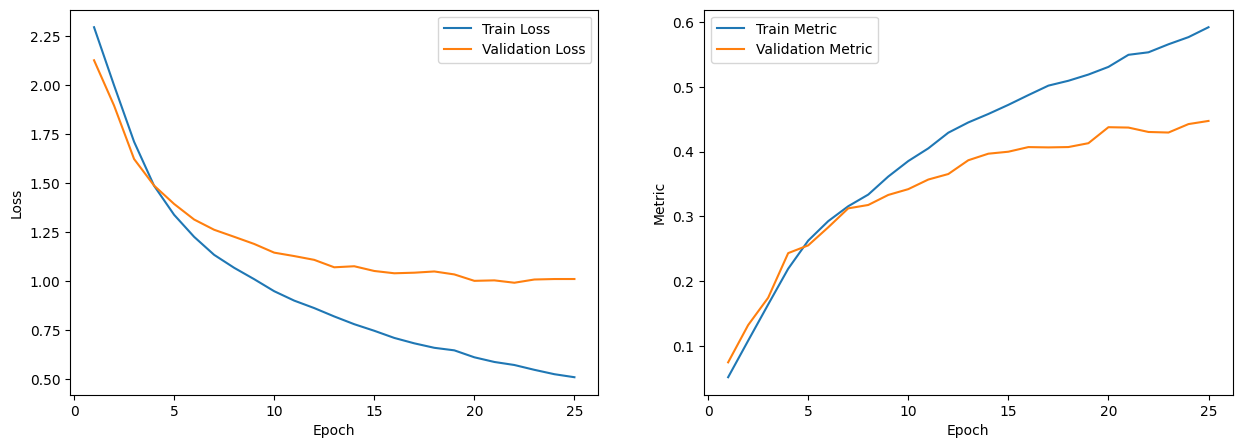

loss: 1.0095615148544312, f1: 0.4474675716088509


<Figure size 640x480 with 0 Axes>

In [ ]:
trainer.train()

Задание 2 (2 балла)
Обучите нейросеть со сверточными слоями с архитектурой похожей на Unet - https://en.wikipedia.org/wiki/U-Net

Не нужно воспроизводить все в точности, главное, чтобы было сокращение длины последовательности с помощью CNN, а затем обратное увеличение длины последовательности до изначальной с residual связями между промежуточными шагами с одинаковыми размерностями. Изменений размерности должно быть хотя бы 3 и соответственно residual связей тоже.

Для повышения размерности используйте keras.layers.UpSampling1D Полученная модель должна давать ненулевое качество на той же самой задаче классификации текстов.

In [23]:
class UNet1DClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, max_len, embedding_dim=100):
        super(UNet1DClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)


        self.conv1_1 = nn.Conv1d(embedding_dim, 128, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv1d(128, 128, kernel_size=3, padding=1)
        self.pool1 = nn.AvgPool1d(kernel_size=2)

        self.conv2_1 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.pool2 = nn.AvgPool1d(kernel_size=2)

        self.conv3_1 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv1d(512, 512, kernel_size=3, padding=1)
        self.pool3 = nn.AvgPool1d(kernel_size=2)


        self.conv4_1 = nn.Conv1d(512, 1024, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv1d(1024, 1024, kernel_size=3, padding=1)


        self.up5 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv5_1 = nn.Conv1d(1024 + 512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv1d(512, 512, kernel_size=3, padding=1)

        self.up6 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv6_1 = nn.Conv1d(512 + 256, 256, kernel_size=3, padding=1)
        self.conv6_2 = nn.Conv1d(256, 256, kernel_size=3, padding=1)

        self.up7 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv7_1 = nn.Conv1d(256 + 128, 128, kernel_size=3, padding=1)
        self.conv7_2 = nn.Conv1d(128, 128, kernel_size=3, padding=1)


        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)


        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)


        c1 = F.relu(self.conv1_1(x))
        c1 = self.dropout(F.relu(self.conv1_2(c1)))
        p1 = self.pool1(c1)

        c2 = F.relu(self.conv2_1(p1))
        c2 = self.dropout(F.relu(self.conv2_2(c2)))
        p2 = self.pool2(c2)

        c3 = F.relu(self.conv3_1(p2))
        c3 = self.dropout(F.relu(self.conv3_2(c3)))
        p3 = self.pool3(c3)


        c4 = F.relu(self.conv4_1(p3))
        c4 = self.dropout(F.relu(self.conv4_2(c4)))


        u5 = self.up5(c4)
        u5 = torch.cat([u5, c3], dim=1)
        c5 = self.dropout(F.relu(self.conv5_1(u5)))
        c5 = F.relu(self.conv5_2(c5))

        u6 = self.up6(c5)
        u6 = torch.cat([u6, c2], dim=1)
        c6 = self.dropout(F.relu(self.conv6_1(u6)))
        c6 = F.relu(self.conv6_2(c6))

        u7 = self.up7(c6)
        u7 = torch.cat([u7, c1], dim=1)
        c7 = self.dropout(F.relu(self.conv7_1(u7)))
        c7 = F.relu(self.conv7_2(c7))


        pooled = self.adaptive_pool(c7)
        flat = pooled.squeeze(-1)
        out = F.relu(self.fc1(flat))
        logits = self.fc2(out)
        return logits

In [24]:
from sklearn.metrics import f1_score, classification_report

def macro_f1(y_true, y_pred_probs):
    y_pred = y_pred_probs.argmax(axis=1)
    return f1_score(y_true, y_pred, average='macro')


model = UNet1DClassifier(
    vocab_size=len(word2id),
    num_classes=len(label2id),
    max_len=MAX_LEN
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 25
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min', factor=0.5, patience=3)
metric = macro_f1

In [25]:
from sklearn.metrics import classification_report
trainer = NN(model=model,
                optimizer=optimizer,
                criterion=criterion,
            	  scheduler = scheduler,
                metric=metric,
                num_epochs=num_epochs,
                wandb_project=False,
                train_loader=train_loader,
                test_loader=test_loader)

<Figure size 640x480 with 0 Axes>

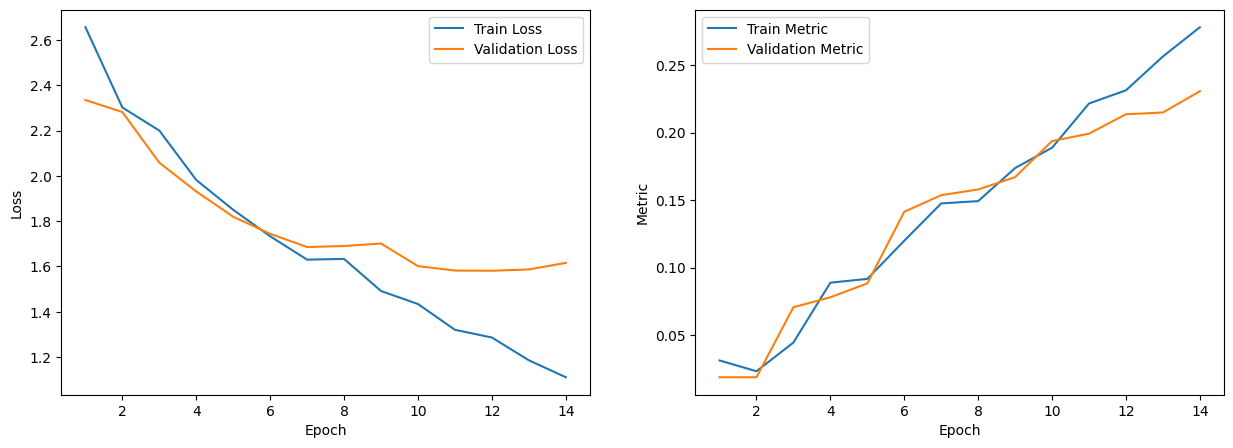

loss: 1.6160245418548584, f1: 0.23076064779848474

=== Classification Report (по лучшей модели) ===

                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00        11
            Спорт       0.82      0.88      0.85       412
          Легпром       0.00      0.00      0.00         2
  Наука и техника       0.39      0.34      0.36       333
      Бывший СССР       0.00      0.00      0.00       301
         Из жизни       0.19      0.20      0.20       156
           Бизнес       0.00      0.00      0.00        49
Силовые структуры       0.00      0.00      0.00       127
   Интернет и СМИ       0.20      0.20      0.20       280
              Мир       0.62      0.78      0.69       787
         Культура       0.40      0.38      0.39       336
       Библиотека       0.00      0.00      0.00         1
      Путешествия       0.00      0.00      0.00        33
    Культпросвет        0.00      0.00      0.00         2
             

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 15/25:   0%|          | 0/39 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]


Early stopping на эпохе 15, лучшая валидационная loss 1.5813


<Figure size 640x480 with 0 Axes>

In [26]:
trainer.train()

In [27]:
model.load_state_dict(torch.load("best_model.pt"))
model.to(device)
model.eval()

UNet1DClassifier(
  (embedding): Embedding(24092, 100)
  (conv1_1): Conv1d(100, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv2_1): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2_2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv3_1): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3_2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv4_1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4_2): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
  (up5): Upsample(scale_factor=2.0, mode='nearest')
  (conv5_1): Conv1d(1536, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv5_2): Con